# Converting HCPh's physio into BIDS

This notebook finalizes the conversion of physiological recordings into BIDS.
Before starting, make sure you run the `splice-runs.py` script on all sessions.
As a result of running `splice-runs.py`, you will have one hdf5 file corresponding to each run in the input dataset.

First, let's import some necessary libraries.

In [1]:
%matplotlib inline

from pathlib import Path
from json import dumps, loads
import string
import numpy as np
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import pandas as pd
from datetime import timezone, timedelta
from collections import defaultdict

from acq2bids import (
    _channel_id,
    _gen_timeseries,
    get_1st_trigger_time,
    RECALIBRATED_SESSION,
    FIRST_O2_SESSION,
    MISSING_RB,
)

import h5py

plt.rcParams["figure.figsize"] = (20, 2.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

Let's define some paths and constants

In [2]:
DATA_PATH = Path("/data/datasets/hcph-pilot-sourcedata/recordings/BIOPAC")
BIDS_PATH = Path("/data/datasets/hcph")

participant = "001"
session = "040"

In the file `code/scans.tsv`, we keep a lookup table of *AcqKnowledge* files generated.
Some sessions (like 13) required restarting *AcqKnowledge* or some other issue and produced several *runs* as a consequence, we'll need to have special care with those.

Prepare repeated metadata across JSON files.
These JSON files may be consolidated at the top level of the BIDS structure for the most part.

## Extracting data from already split HDF5 files
Once the physiological recordings have been already split by runs with `split-runs.py`, we may finalize conversion to BIDS:


In [4]:
# src_file = DATA_PATH / f"sub-{participant}_ses-{session}_acq-reliability_dir-LR_physio.hdf5"
# src_file = DATA_PATH / f"sub-{participant}_ses-{session}_task-bht_dir-LR_physio.hdf5"
src_file = DATA_PATH / f"sub-{participant}_ses-{session}_task-qct_dir-AP_physio.hdf5"
# src_file = DATA_PATH / f"sub-{participant}_ses-{session}_task-rsmovie_dir-LR_physio.hdf5"
out_path = (
    BIDS_PATH
    / f"sub-{participant}"
    / f"ses-{session}"
    / ("func" if "task-" in src_file.name else "dwi")
)

channels = {}

with h5py.File(src_file, "r") as h5f:
    start_recording = np.datetime64(
        h5f.attrs["start_recording"].decode("utf-8").rsplit("+", 1)[0]
    )
    start_run = h5f.attrs["start_run"]
    stop_run = h5f.attrs["stop_run"]
    
    for i, key in enumerate(h5f.keys()):
        metadata = h5f[key].attrs
        channel_id = _channel_id(metadata["name"])
        channels[channel_id] = dict(metadata.items())
        channels[channel_id]["num"] = int(key.split("_")[-1])
        channels[channel_id]["data"] = h5f[key]["data"][()]

if session.startswith("pilot") or int(session) < FIRST_O2_SESSION:
    channels.pop("respiratory2", None)


## Extracting the trigger and other digital signals
We are ready to extract the trigger channel, identify the first trigger and store the corresponding `stim.tsv.gz` files.

First, let's have a look at the trigger signal throughout the timespan of the active MRI scanning for this run.
In this visualization, we are not showing the *preamble* (i.e., a few seconds that were recorded before scanning started) or the *appendix* (we split the recordings just before the next sequence starts).

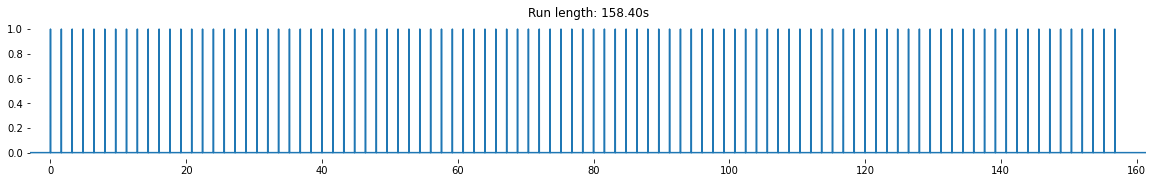

In [5]:
_, first_trigger_t = get_1st_trigger_time(channels, start_run)

plt.plot(channels["trigger"]["timeseries"], channels["trigger"]["data"] / 5)
plt.xlim((-3, stop_run - start_run + 3))
plt.title(f"Run length: {stop_run - start_run:0.2f}s");


Now, we can create the sidecar JSON and proceed with storing the data in a `tsv.gz` file:

In [6]:
trigger_filepath = out_path / src_file.name.replace("_physio.hdf5", "_stim.tsv.gz")

columns = ["trigger"] + sorted([_ch for _ch in channels.keys() if _ch.startswith("stim")])
trigger_data = {name: channels[name]["data"] for name in columns}

trigger_sidecar = {
    "SamplingFrequency": channels["trigger"]["frequency"],
    "StartTime": channels["trigger"]["timeseries"][0],
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col in columns:
    trigger_sidecar[col] = {
        "Description": f"Pulse signal [{channels[col]['name']}] generated with Psychopy",
        "Units": channels[col]["units"],
        "Model": "STP100D",
    }

trigger_sidecar["trigger"]["Description"] = f"Scanner trigger signal [{channels['trigger']['name']}]."

if out_path.name == "dwi":
    trigger_sidecar["trigger"]["Description"] += (
        " IMPORTANT! The DWI sequence sends triggers during calibration."
        " Therefore, a total of 203 trigger pulses SHOULD be discarded at the beginning of the run"
        " (corresponding to 2 x 87 slices single slice mode, plus 29 for one multi-slice volume)."
    )

# Uncomment to write JSON to disk
# (trigger_filepath.parent / trigger_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(trigger_sidecar, indent=2))

# Uncomment to write data to disk
# pd.DataFrame(trigger_data).to_csv(
#     trigger_filepath,
#     compression="gzip",
#     header=False,
#     sep="\t",
#     na_rep="n/a",
# )

## Extracting cardiac signal

Once the trigger and other digital signals are extracted and stored, we proceed with the cardiac signal (ECG):

In [7]:
recording = "cardiac"

# Generate BIDS name
recording_filepath = out_path / src_file.name.replace("_physio.hdf5", f"_recording-{recording}_physio.tsv.gz")

# Generate the time axis
channel_names = sorted([key for key in channels.keys() if key.startswith(recording)])

# All recordings MUST have the same frequency and hence, have same time axis
timeseries = _gen_timeseries(channels[channel_names[0]], offset=first_trigger_t)
for name in channel_names:
    channels[name]["timeseries"] = timeseries

# Prepare metadata
sidecar = loads(Path(f"defaults_{recording}.json").read_text()).copy()
sidecar.update({
    "SamplingFrequency": channels[channel_names[0]]["frequency"],
    "StartTime": timeseries[0],
})

recording_data = {}  # Prepare dataframe
for colname, name in zip(sidecar["Columns"], channel_names):
    sidecar[colname]["Units"] = channels[name]["units"]
    recording_data[colname] = channels[name]["data"]

sidecar["Columns"] = list(recording_data.keys())

# We can store metadata now
# (recording_filepath.parent / recording_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(sidecar, indent=2))

recording_filepath

PosixPath('/data/datasets/hcph/sub-001/ses-040/func/sub-001_ses-040_task-qct_dir-AP_recording-cardiac_physio.tsv.gz')

Now, let's peek into the data.
First, we check the frequency is 5 kHz.
Then, we visualize the trigger channel and extract the onset location.

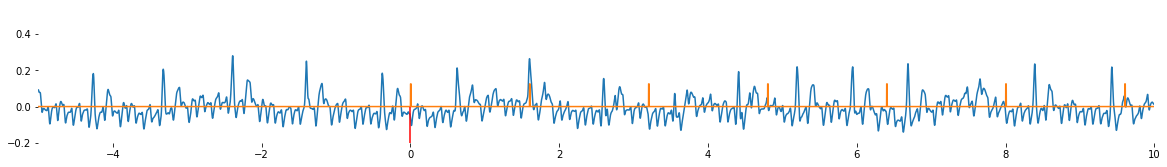

In [8]:
# plot it
plt.plot(channels["cardiac"]["timeseries"], channels["cardiac"]["data"])
plt.plot(channels["trigger"]["timeseries"], channels["trigger"]["data"] / 40)
plt.vlines(0, -0.2, 0.0, colors="r")
plt.xlim(-5, 10)
plt.ylim(bottom=-0.2);

In [9]:
# pd.DataFrame(recording_data).to_csv(
#     recording_filepath,
#     compression="gzip",
#     header=False,
#     sep="\t",
#     na_rep="n/a",
# )

## Extracting respiratory signals

Next, we extract respiratory signals:

- respiration belt and CO<sub>2</sub>, for all sessions before session 11
- respiration belt, CO<sub>2</sub>, and O<sub>2</sub>, for all sessions from 11 onward

In [10]:
recording = "respiratory"

# Generate BIDS name
recording_filepath = out_path / src_file.name.replace("_physio.hdf5", f"_recording-{recording}_physio.tsv.gz")

# Generate the time axis
channel_names = sorted([key for key in channels.keys() if key.startswith(recording)])

# All recordings MUST have the same frequency and hence, have same time axis
timeseries = _gen_timeseries(channels[channel_names[0]], offset=first_trigger_t)
for name in channel_names:
    channels[name]["timeseries"] = timeseries

# Prepare metadata
sidecar = loads(Path(f"defaults_{recording}.json").read_text()).copy()
sidecar.update({
    "SamplingFrequency": channels[channel_names[0]]["frequency"],
    "StartTime": timeseries[0],
})

recording_data = {}  # Prepare dataframe
for colname, name in zip(sidecar["Columns"], channel_names):
    sidecar[colname]["Units"] = channels[name]["units"]
    recording_data[colname] = channels[name]["data"]

sidecar["Columns"] = list(recording_data.keys())

# We can store metadata now
# (recording_filepath.parent / recording_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(sidecar, indent=2))

recording_filepath

PosixPath('/data/datasets/hcph/sub-001/ses-040/func/sub-001_ses-040_task-qct_dir-AP_recording-respiratory_physio.tsv.gz')

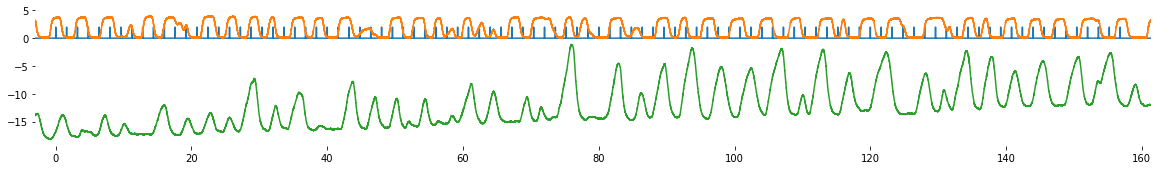

In [11]:
# plot it
plt.plot(channels["trigger"]["timeseries"], 0.5 * channels["respiratory1"]["data"].max() * channels["trigger"]["data"] / channels["trigger"]["data"].max())

plt.plot(channels["respiratory1"]["timeseries"], channels["respiratory1"]["data"])
plt.xlim((-3, stop_run - start_run + 3));
plt.plot(channels["respiratory0"]["timeseries"], channels["respiratory1"]["data"].max() * channels["respiratory0"]["data"] / channels["respiratory0"]["data"].max())
# plt.xlim(-5, 10)
# plt.ylim(bottom=-0.2);

In [ ]:
# pd.DataFrame(recording_data).to_csv(
#     recording_filepath,
#     compression="gzip",
#     header=False,
#     sep="\t",
#     na_rep="n/a",
# )